In [ ]:
!pip3 install pandas_ta

     |████████████████████████████████| 92kB 8.5MB/s 
  Created wheel for pandas-ta: filename=pandas_ta-0.2.45b0-cp37-none-any.whl size=175305 sha256=b7ed1a66074c6c20ea1b67e52fd13a0270f4c54ba2178351e84728c4619d74cc
  Stored in directory: /root/.cache/pip/wheels/78/76/74/e4b09c98fc91d7e1e0a56f4fe067796f216deacaa509234579
Successfully built pandas-ta


In [ ]:
# Importeer de benodigde bibliotheken
import pandas as pd
import pandas_ta as pta
from pandas import DataFrame
import numpy as np


In [ ]:
# Load data
df = pd.read_json("/content/drive/MyDrive/Colab Notebooks/data/ETH_USDT-1d.json")
df.columns=['date','open','high','low','close','volume']
df['date']=(pd.to_datetime(df['date'],unit='ms'))
df.tail(5)

,date,open,high,low,close,volume
994,2021-05-28,2742.23,2762.45,2327.38,2412.10,1.554585e+06
995,2021-05-29,2412.34,2574.27,2204.10,2278.74,1.379427e+06
996,2021-05-30,2278.74,2476.42,2180.53,2385.98,1.151113e+06
997,2021-05-31,2385.82,2720.00,2271.44,2706.15,1.307958e+06
998,2021-06-01,2706.15,2740.00,2523.74,2634.57,1.179577e+06


In [ ]:
# Gebruik pandas_ta om de eerste supertrend (Ultra) van de strategie te berekenen (default waarden zijn: period=7, multiplier=3)
# gebruik maken van deze indicator heeft nog niet tot gevolg dat deze ook aan de dataframe wordt toegevoegd. Dat gebeurd in de cel hierna.
pta.supertrend(high=df['high'], low=df['low'], close=df['close'], period=7, multiplier=3).tail(5)

,SUPERT_7_3.0,SUPERTd_7_3.0,SUPERTl_7_3.0,SUPERTs_7_3.0
994,3908.858163,-1,NaN,3908.858163
995,3799.380219,-1,NaN,3799.380219
996,3664.023759,-1,NaN,3664.023759
997,3664.023759,-1,NaN,3664.023759
998,3664.023759,-1,NaN,3664.023759


In [ ]:
# Hierboven zagen we dat kolom "SUPERTd_7_4.0" (d = direction?) aangeeft of er een bearish trend (-1) is of juist bullish trend (1).
#
# Dit wetende, ga ik een viertal supertrend kolommen maken in de dataframe die voor elke supertrend (Ultra, Long, Medium, Short) een signaal geven.
# Nb. aanpassen van period naar een ander getal heeft een bug. De berekende waarde blijf op 7 steken. Daarom blijf ik de default periode gebruiken.
df['st_ultra'] = pta.supertrend(high=df['high'], low=df['low'], close=df['close'], period=7, multiplier=3)['SUPERTd_7_3.0']
df['st_long'] = pta.supertrend(high=df['high'], low=df['low'], close=df['close'], period=7, multiplier=1.8)['SUPERTd_7_1.8']
df['st_medium'] = pta.supertrend(high=df['high'], low=df['low'], close=df['close'], period=7, multiplier=1.3)['SUPERTd_7_1.3']
df['st_short'] = pta.supertrend(high=df['high'], low=df['low'], close=df['close'], period=7, multiplier=0.8)['SUPERTd_7_0.8']
df[['date','st_ultra','st_long','st_medium','st_short']]

,date,st_ultra,st_long,st_medium,st_short
0,2018-09-07,1,1,1,1
1,2018-09-08,1,1,1,1
2,2018-09-09,1,1,1,1
3,2018-09-10,1,1,1,1
4,2018-09-11,1,1,1,1
...,...,...,...,...,...
994,2021-05-28,-1,-1,1,1
995,2021-05-29,-1,-1,1,-1
996,2021-05-30,-1,-1,1,-1
997,2021-05-31,-1,-1,1,1


# Nu de kolommen gemaakt zijn ga ik de regels van de strategie toepassen. Eerst pseudo code en daarna echte code:
Als st_ultra is 1, dan  
    als st_long (1) + st_medium (1) + st_short (1) = 3
    Ga long met R:R  = 1:5  
    als st_long (-1) + st_medium (-1) + st_short (-1) = -3
    Ga short met R:R  = 1:2  

Als st_ultra is -1, dan  
    als st_long (1) + st_medium (1) + st_short (1) = 3
    Ga long met R:R  = 1:2  
    als st_long (-1) + st_medium (-1) + st_short (-1) = -3
    Ga short met R:R  = 1:5  

In [ ]:
# Long Trades
df['long_1_5'] = (df['st_ultra'] == 1) & (df['st_long'] + df['st_medium'] + df['st_short'] == 3)
df['long_1_2'] = (df['st_ultra'] == -1) & (df['st_long'] + df['st_medium'] + df['st_short'] == 3)
# Short trades (voor Binance niet relevant dus hier gaat verder niets meer mee gebeuren)
df['short_1_5'] = (df['st_ultra'] == -1) & (df['st_long'] + df['st_medium'] + df['st_short'] == -3)
df['short_1_2'] = (df['st_ultra'] == 1) & (df['st_long'] + df['st_medium'] + df['st_short'] == -3)

# zien of long_1_5 True waardes heeft:
df[['date','close','long_1_5','short_1_2','short_1_5','long_1_2']][df['long_1_5'] == True]

,date,close,long_1_5,short_1_2,short_1_5,long_1_2
0,2018-09-07,215.22,True,False,False,False
1,2018-09-08,196.71,True,False,False,False
2,2018-09-09,195.81,True,False,False,False
3,2018-09-10,197.15,True,False,False,False
4,2018-09-11,185.18,True,False,False,False
...,...,...,...,...,...,...
974,2021-05-08,3910.26,True,False,False,False
975,2021-05-09,3923.95,True,False,False,False
976,2021-05-10,3945.88,True,False,False,False
977,2021-05-11,4173.45,True,False,False,False


Bovenstaande lijkt nu goede resultaten te bieden. het is echter nog niet met de chart geverifieerd.

Hieronder nu het signaal maken waarop gewaarschuwd wordt voor een trendverandering. Dit stukje code is afkomstig van CryptoMaven bot.


```
df['POS_adv_changed'] = df['POS_adv'].shift(+1)==df['POS_adv']
df[['POS_adv_changed','POS_adv','# openTime']].tail(30)
```

In [ ]:
# kolommen [['long_1_5','short_1_2','short_1_5','long_1_2']] tonen True als indicatoren zeggen op welke candles er een uptrend gaande is.
# Ik wil weten wanneer er van trend gewisseld is. Dat kan door een nieuwe kolom te introduceren die waarneemt of een cel is veranderd t.o.v. de vorige cel.
# Vergelijk of de vorige cel gelijk is met de huidige cel. Als dat niet zo is, dan is de waarde 'False' en daarmee een trigger dat er iets veranderd is.
df['long_1_5_samecells'] = df['long_1_5'].shift(1)==df['long_1_5']
# Wanneer 'False' getoond wordt, dan is de trend gewijzigd van bear naar bull of andersom.
# Toon alle 'False' signalen in combinatie met een positie signaal, dan is het instappen.

# Als long == True en signal == False (beetje tegenstrijdige melding maar het is False t.o.v. de vorige cel), dan definitief instapsignaal
df[['date','close','long_1_5','long_1_5_samecells']][df['long_1_5'] == True][df['long_1_5_samecells'] == False]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


,date,close,long_1_5,long_1_5_samecells
0,2018-09-07,215.22,True,False
13,2018-09-20,224.00,True,False
60,2018-11-06,220.74,True,False
104,2018-12-20,114.05,True,False
117,2019-01-02,152.01,True,False
154,2019-02-08,119.25,True,False
207,2019-04-02,163.31,True,False
241,2019-05-06,173.00,True,False
254,2019-05-19,259.51,True,False
281,2019-06-15,267.82,True,False


Bovenstaande dient nu uitgezocht te worden. Dit zijn LONG signalen in een bullish LONG supertrend (Ultra)

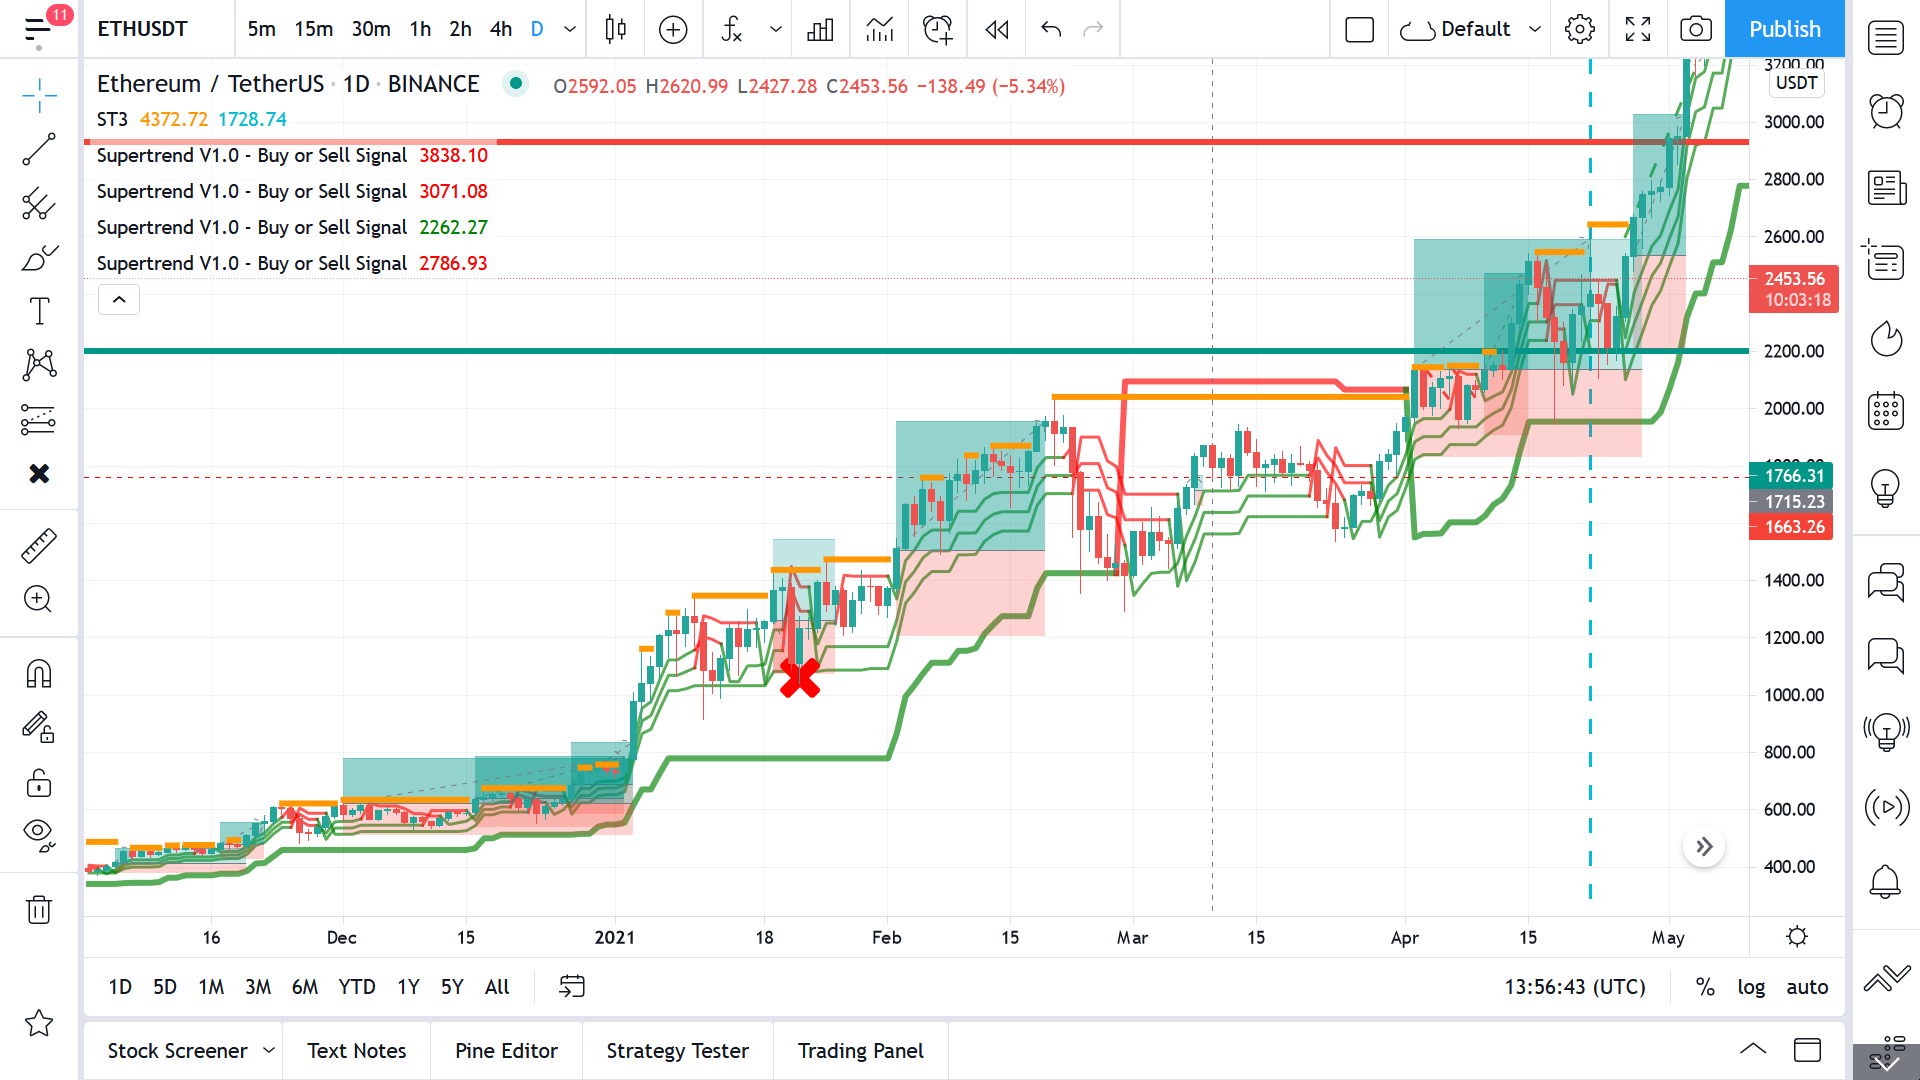

Alle signalen zijn valide en van de 10 gecontroleerde signalen waren er 9 met profit!

Nu de overige supertrend signalen definieren:

In [ ]:
# Long Signaleringen in het dataframe opnemen zodat hierop met Freqtrade gereageerd kan worden:
# Binance heeft alleen Long trades...

# De volledige code per supertrend lijn:
df['long_1_5_samecells'] = df['long_1_5'].shift(1)==df['long_1_5']
df['long_1_5_trendchange'] = df['long_1_5_samecells'] == True
df['long_1_5_Signal'] = (df['long_1_5'] == True) & (df['long_1_5_trendchange'] == True)

df['long_1_2_samecells'] = df['long_1_2'].shift(1)==df['long_1_2']
df['long_1_2_trendchange'] = df['long_1_2_samecells'] == True
df['long_1_2_Signal'] = (df['long_1_2'] == True) & (df['long_1_2_trendchange'] == False)

# Print high R:R trades (Ultratrend is bullish)
df[['date','close','long_1_5','long_1_5_samecells','long_1_5_trendchange','long_1_5_signal']][df['long_1_5_signal'] == True]

,date,close,long_1_5,long_1_5_samecells,long_1_5_trendchange,long_1_5_signal
1,2018-09-08,196.71,True,True,True,True
2,2018-09-09,195.81,True,True,True,True
3,2018-09-10,197.15,True,True,True,True
4,2018-09-11,185.18,True,True,True,True
5,2018-09-12,183.12,True,True,True,True
...,...,...,...,...,...,...
994,2021-05-28,2412.10,False,True,True,True
995,2021-05-29,2278.74,False,True,True,True
996,2021-05-30,2385.98,False,True,True,True
997,2021-05-31,2706.15,False,True,True,True


In [ ]:
# Print low R:R trades (Ultratrend = bearish)
df[['date','close','long_1_2','long_1_2_signal','long_1_2_GO']][df['long_1_2_GO'] == True]

# Opmerking: Deze kloppen ook! :-) :-)

,date,close,long_1_2,long_1_2_signal,long_1_2_GO
58,2018-11-04,212.11,True,False,True
102,2018-12-18,100.39,True,False,True
203,2019-03-29,143.25,True,False,True
372,2019-09-14,188.13,True,False,True
397,2019-10-09,192.62,True,False,True
413,2019-10-25,181.50,True,False,True
764,2020-10-10,370.52,True,False,True
912,2021-03-07,1726.16,True,False,True
934,2021-03-29,1816.74,True,False,True


In [ ]:
# Toon te rcontrole de laatste 50 entries (eyeballing)
df.tail(50)

,date,open,high,low,close,volume,st_ultra,st_long,st_medium,st_short,long_1_5,long_1_2,short_1_5,short_1_2,long_1_5_signal,long_1_5_GO,long_1_2_signal,long_1_2_GO
949,2021-04-13,2137.86,2318.00,2135.53,2299.19,7.826086e+05,1,1,1,1,True,False,False,False,True,False,True,False
950,2021-04-14,2299.19,2447.29,2281.33,2432.60,9.729316e+05,1,1,1,1,True,False,False,False,True,False,True,False
951,2021-04-15,2432.59,2543.47,2400.00,2514.04,6.819510e+05,1,1,1,1,True,False,False,False,True,False,True,False
952,2021-04-16,2514.04,2548.29,2300.00,2422.67,9.991638e+05,1,1,1,1,True,False,False,False,True,False,True,False
953,2021-04-17,2422.38,2495.00,2310.00,2317.60,6.242323e+05,1,1,1,-1,False,False,False,False,False,False,True,False
954,2021-04-18,2317.65,2340.00,1946.80,2235.64,1.475384e+06,1,1,-1,-1,False,False,False,False,True,False,True,False
955,2021-04-19,2235.65,2300.00,2080.00,2161.12,8.205923e+05,1,-1,-1,-1,False,False,False,True,True,False,True,False
956,2021-04-20,2161.12,2346.62,2055.00,2330.03,9.922408e+05,1,-1,-1,1,False,False,False,False,True,False,True,False
957,2021-04-21,2330.26,2469.54,2235.16,2357.06,1.177886e+06,1,-1,-1,1,False,False,False,False,True,False,True,False
958,2021-04-22,2357.06,2644.47,2303.44,2397.94,2.220753e+06,1,-1,1,1,False,False,False,False,True,False,True,False


## Berekenen van stoploss en take profit onder Long condities

Onder ultratrend = R:R 1:2
Boven ultratrend = R:R 1:5


**Stoploss**
In alle gevallen is de stoploss de long supertrend waarde van het instapmoment.

Dus de SL price cel mag alleen gevuld worden op het moment dat GO bepaald wordt. Daarna geldt deze alleen als exit indicator (close < stoploss) o.i.d.

**Takeprofit**
In alle gevallen is de takeprofit een berekening van de stoploss price. Dus als het bedrag  van de stoploss is bepaald, dan een calculatie op de takeprofit prijs.

**voorbeeld**
long_1_5_GO signaal wordt gegenereerd. Op dat moment wordt de long_supertrend stoploss geregistreerd (cellwaarde van pandas_ta supertrend cel.shift(1))
bv. 
```
  entry = 25.436,-  
  sl = 25.133,- (= supertrend waarde pandas_ta berekening)
  verschil = 25.436 - 25.133 = 303,- (= SL distance)
```
SL distance is 1 uit 1:1,5 dus take-profit is 1,5 * SL distance:
```
  1,5 * 303 = 454,50
  TP = 25.436 + 454,50 = 25.890,50
```



In [ ]:
# Terug naar de pandas_ta berekening voor supertrend. Alleen voor st_long
# df['st_long'] = pta.supertrend(high=df['high'], low=df['low'], close=df['close'], period=10, multiplier=1.8)['SUPERTd_7_1.8']
pta.supertrend(high=df['high'], low=df['low'], close=df['close'], period=10, multiplier=1.8).tail(50)

,SUPERT_7_1.8,SUPERTd_7_1.8,SUPERTl_7_1.8,SUPERTs_7_1.8
949,2005.154240,1,2005.154240,NaN
950,2131.682492,1,2131.682492,NaN
951,2235.447707,1,2235.447707,NaN
952,2235.447707,1,2235.447707,NaN
953,2235.447707,1,2235.447707,NaN
954,2235.447707,1,2235.447707,NaN
955,2535.934579,-1,NaN,2535.934579
956,2535.934579,-1,NaN,2535.934579
957,2535.934579,-1,NaN,2535.934579
958,2535.934579,-1,NaN,2535.934579


In [ ]:
# Tussen 2021-05-16 en 2021-05-17 is de ST_long gewijzigd van 1 naar -1.
# 16-5 = 3368.151263
# 17-5 = 4155.371616 	

Op dit moment kom ik er achter waarom bij de supertrend SUPERT_7_1.8 zie staan. 7 is voor periods. Ondanks dat ik in de calculatie 10 heb opgegeven blijft deze 7 berekenen. In de praktijk is het dus zo dat de waarden voor de supertrends niet overeenkomen met die van Tradingview (ondanks dat de instapsignalen wel elke keer kloppen).

Mogelijk zal ik de Tradingview moeten aanpassen als dit een bug blijkt te zijn. Dan zou voor de **ultratrent een factor 3** van toepassing moeten zijn en voor de andere trends nog nader te bepalen...

Uitzoeken wat er aan de hand is...

In [ ]:
# Item 963 is op 27-4-21 en een bullish entry (klopt).
# Data is: 
#      SUPERT_7_1.8 	SUPERTd_7_1.8 	SUPERTl_7_1.8 	SUPERTs_7_1.8
#963 	2168.421217 	  1 	            2168.421217 	   NaN


In bovenstaande geval heeft de **SUPERT_7_1.8** kolom altijd de waarde van de supertrend positie. Deze kolom kan daarom gebruikt worden voor de berekening van SL afstand en TP punt.

In [ ]:
df.tail(50)

,date,open,high,low,close,volume,st_ultra,st_long,st_medium,st_short,long_1_5,long_1_2,short_1_5,short_1_2,long_1_5_signal,long_1_5_GO,long_1_2_signal,long_1_2_GO,st_ultra_value,st_long_value,TP_bullish_ultratrend,TP_bearish_ultratrend,exit_1_5,exit_1_2
949,2021-04-13,2137.86,2318.00,2135.53,2299.19,7.826086e+05,1,1,1,1,True,False,False,False,True,False,True,False,1734.296645,2005.154240,2336.918640,2297.106912,False,False
950,2021-04-14,2299.19,2447.29,2281.33,2432.60,9.729316e+05,1,1,1,1,True,False,False,False,True,False,True,False,1847.359982,2131.682492,2550.451262,2500.199010,False,False
951,2021-04-15,2432.59,2543.47,2400.00,2514.04,6.819510e+05,1,1,1,1,True,False,False,False,True,False,True,False,1946.652127,2235.447707,2728.303439,2669.160751,False,False
952,2021-04-16,2514.04,2548.29,2300.00,2422.67,9.991638e+05,1,1,1,1,True,False,False,False,True,False,True,False,1946.652127,2235.447707,2931.928439,2848.350751,False,False
953,2021-04-17,2422.38,2495.00,2310.00,2317.60,6.242323e+05,1,1,1,-1,False,False,False,False,False,False,True,False,1946.652127,2235.447707,2702.778439,2646.698751,False,False
954,2021-04-18,2317.65,2340.00,1946.80,2235.64,1.475384e+06,1,1,-1,-1,False,False,False,False,True,False,True,False,1946.652127,2235.447707,2440.953439,2416.292751,False,False
955,2021-04-19,2235.65,2300.00,2080.00,2161.12,8.205923e+05,1,-1,-1,-1,False,False,False,True,True,False,True,False,1946.652127,2535.934579,1785.223132,1875.308506,True,False
956,2021-04-20,2161.12,2346.62,2055.00,2330.03,9.922408e+05,1,-1,-1,1,False,False,False,False,True,False,True,False,1946.652127,2535.934579,1598.898132,1711.342506,True,False
957,2021-04-21,2330.26,2469.54,2235.16,2357.06,1.177886e+06,1,-1,-1,1,False,False,False,False,True,False,True,False,1946.652127,2535.934579,2021.748132,2083.450506,True,False
958,2021-04-22,2357.06,2644.47,2303.44,2397.94,2.220753e+06,1,-1,1,1,False,False,False,False,True,False,True,False,1946.652127,2535.934579,2088.748132,2142.410506,True,False


In [ ]:
# Open == Entry price van de eerstvolgende candle na constatering instapmoment.
df['st_long_value'] = pta.supertrend(high=df['high'], low=df['low'], close=df['close'], period=7, multiplier=1.8)['SUPERT_7_1.8']
SL_distance = df['open'] - df['st_long_value']
df['TP_bullish_ultratrend'] = df['open'] + (1.5 * SL_distance)
df['TP_bearish_ultratrend'] = df['open'] + (1.2 * SL_distance)

df['exit_1_5'] =  (df['st_ultra'] == 1) & (df['close'] > df['TP_bullish_ultratrend'])
df['exit_1_2'] =  (df['st_ultra'] == -1) & (df['close'] > df['TP_bearish_ultratrend'])
df[['exit_1_5','exit_1_2']].tail(50)
# # Exit
# if df['st_ultra'] == 1:
#   if df['close'] > TP_bullish_ultratrend:
#     exit = True
# elif df['st_ultra'] == -1:
#   if df['close'] > TP_bearish_ultratrent:
#     exit = True
# elif df['close'] < df['st_long_value']:
#   exit = True



,exit_1_5,exit_1_2
949,False,False
950,False,False
951,False,False
952,False,False
953,False,False
954,False,False
955,True,False
956,True,False
957,True,False
958,True,False


in https://github.com/twopirllc/pandas-ta/commit/11e7eda03f9ab68abf6173ce16c67d9b8785a1d9

``pandas_ta/trend/supertrend.py``

Zie ik dat de supertrend functie de volgende waardes accepteerd:

``def supertrend(self, high=None, low=None, close=None, period=None, multiplier=None, mamode=None, drift=None,
                   offset=None, **kwargs):``

In [ ]:
# Supertrend snippet uit pandas-ta

# -*- coding: utf-8 -*-
import numpy as np
from pandas import DataFrame
from ..utils import get_offset, verify_series
from ..volatility import atr

def supertrend(high, low, close, period=None, multiplier=None, mamode=None, drift=None, offset=None, **kwargs):
    # indicator : supertrend
    # Validate Arguments
    high = verify_series(high)
    low = verify_series(low)
    close = verify_series(close)
    offset = get_offset(offset)
    period = int(period) if period and period > 0 else 10
    multiplier = float(multiplier) if multiplier and multiplier > 0 else 1.5
    min_periods = int(kwargs['min_periods']) if 'min_periods' in kwargs and kwargs[
        'min_periods'] is not None else period

    st_updown = np.zeros(shape=(len(close)))
    strend = np.zeros(shape=(len(close)))

    # Bands initial calculation
    midrange = 0.5 * (high + low)
    distance = multiplier * atr(high, low, close, period, mamode, drift, offset, min_periods=min_periods)
    lowerband = midrange - distance
    upperband = midrange + distance

    # final calculation loop
    for i in range(1, len(close)):
        if close[i] > upperband[i-1]:
            st_updown[i] = 1
        elif close[i] < lowerband[i-1]:
            st_updown[i] = -1
        else:
            st_updown[i] = st_updown[i-1]
        if st_updown[i] > 0 and lowerband[i] < lowerband[i-1]:
            lowerband[i] = lowerband[i-1]
        if st_updown[i] < 0 and upperband[i] > upperband[i-1]:
            upperband[i] = upperband[i-1]
        if st_updown[i] < 0 and st_updown[i-1] > 0:
            upperband = midrange + distance
        if st_updown[i] > 0 and st_updown[i-1] < 0:
            lowerband = midrange - distance
        if st_updown[i] < 0 :
            strend[i] = upperband[i]
        else:
            strend[i] = lowerband[i]


    # Prepare DataFrame to return
    data = {f"supertrend_{period}_{multiplier}": strend, f"st_updown_{period}_{multiplier}": st_updown}
    supertrend_df = DataFrame(data)
    supertrend_df.name = f"supertrend_{period}_{multiplier}"
    supertrend_df.category = 'trend'



    # Apply offset if needed
    if offset != 0:
        supertrend_df = supertrend_df.shift(offset)

    # Handle fills
    if 'fillna' in kwargs:
        supertrend_df.fillna(kwargs['fillna'], inplace=True)

    if 'fill_method' in kwargs:
        supertrend_df.fillna(method=kwargs['fill_method'], inplace=True)



    return supertrend_df

supertrend.__doc__ = \
"""Supertrend (supertrend)
Supertrend is a trend indicator. It was created by Olivier Seban
Sources: 
https://www.abcbourse.com/apprendre/11_le_supertrend.html
(in french, but many other can be found using a search engine)
Calculation:
    Default Inputs:
        period = 10
        multiplier = 1.5
Args:
    high (pd.Series): Series of 'high's
    low (pd.Series): Series of 'low's
    close (pd.Series): Series of 'close's
    
    offset (int): How many periods to offset the result.  Default: 0
Kwargs:
    fillna (value, optional): pd.DataFrame.fillna(value)
    fill_method (value, optional): Type of fill method
Returns:
    pd.DataFrame: supertrend, st_updown, slowk, slowd columns.
""" 
